In [1]:
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('stopwords') # download the stopwords
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt')+ gutenberg.sents('austen-emma.txt')+ gutenberg.sents('austen-persuasion.txt')
# sanity check 16498. 
print(len(austen))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
16498


In [2]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

#### 2. Preprocess the Training Corpus

In [0]:
 # Filter out stopwords, empty strings, special characters and digits
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

stop_list = stopwords.words('english') + list(string.punctuation)
normalized_corpus = []

for i in range(len(austen)):
    result = [] # clears result after each sentence
    for w in austen[i]:
        w = w.lower()  #change to lower case
        w = w.strip()      #remove white spaces
        if w not in stop_list and w.isalpha(): #filter out special characters,stop words and not a digit
                result.append(w)
    if len(result) > 2:  # make sure that each line contains a minimum of 2 words for the normalize corpus e.g X 'chapter'
        normalized_corpus.append(result)

In [33]:
print("Processed line: ",normalized_corpus[10])
print("Length of processed corpus: ", len(normalized_corpus))

Processed line:  ['therefore', 'succession', 'norland', 'estate', 'really', 'important', 'sisters', 'fortune', 'independent', 'might', 'arise', 'father', 'inheriting', 'property', 'could', 'small']
Length of processed corpus:  13923


#### 3. Create the Corpus Vocabulary and Preparing the Dataset

In [5]:
from keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words = None) 
tok.fit_on_texts(normalized_corpus)
word2idx = tok.word_index
idx2word = dict([[v,k] for k,v in word2idx.items()])

Using TensorFlow backend.


In [0]:
#sents as ids
sents_as_ids = []
for i in range(len(normalized_corpus)):
    converted = [] # empty list for every new line in corpus
    for word in normalized_corpus[i]:
        converted.append(word2idx[word]) #create sentence as a list of ids
    sents_as_ids.append(converted)

Set vocab_size and embed_size

In [0]:
vocab_size = len(word2idx) + 1 #1 was added for zero padding
embed_size = 100 #100D embeddings

Sanity Check:

In [8]:
print('Number of unique words: ', len(word2idx))

Number of unique words:  10084


In [9]:
print('\nSample word2idx: ', list(word2idx.items())[100:120])


Sample word2idx:  [('dashwood', 101), ('something', 102), ('feelings', 103), ('found', 104), ('yet', 105), ('perhaps', 106), ('fairfax', 107), ('family', 108), ('till', 109), ('present', 110), ('poor', 111), ('half', 112), ('going', 113), ('look', 114), ('love', 115), ('believe', 116), ('colonel', 117), ('almost', 118), ('jennings', 119), ('heart', 120)]


In [10]:
print('\nSample idx2word: ', list(idx2word.items())[:10])


Sample idx2word:  [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]


In [11]:
print('\nSample normalized corpus: ', normalized_corpus[:3])


Sample normalized corpus:  [['sense', 'sensibility', 'jane', 'austen'], ['family', 'dashwood', 'long', 'settled', 'sussex'], ['estate', 'large', 'residence', 'norland', 'park', 'centre', 'property', 'many', 'generations', 'lived', 'respectable', 'manner', 'engage', 'general', 'good', 'opinion', 'surrounding', 'acquaintance']]


In [35]:
print('\nAbove sentence as a list of ids:' ,sents_as_ids[:3])


Above sentence as a list of ids: [[305, 1379, 75, 4292], [108, 101, 57, 333, 2586], [1022, 404, 1626, 597, 554, 2784, 1023, 66, 4293, 511, 768, 160, 1164, 199, 15, 190, 3041, 147]]


#### 4. Generating Training Instances

In [0]:
from keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sent,vocabulary_size = vocab_size, window_size = 5) for sent in sents_as_ids]


Sanity check:

In [14]:
pairs,labels = skip_grams[0][0],skip_grams[0][1]
for i in range (len(pairs)):
    print('({:s}({:d}), {:s}, ({:d})) -> {:d}'.format(
            idx2word[pairs[i][0]],pairs[i][0],        #the first word and its index
            idx2word[pairs[i][1]],pairs[i][1],        #the second word and its index
            labels[i]))                               #the label

(austen(4292), sensibility, (1379)) -> 1
(sense(305), sensibility, (1379)) -> 1
(sense(305), blossoms, (5304)) -> 0
(sensibility(1379), enlightened, (5766)) -> 0
(sensibility(1379), sense, (305)) -> 1
(jane(75), austen, (4292)) -> 1
(sensibility(1379), vowed, (5599)) -> 0
(sensibility(1379), jane, (75)) -> 1
(sense(305), jane, (75)) -> 1
(jane(75), sensibility, (1379)) -> 1
(austen(4292), heyday, (9687)) -> 0
(austen(4292), sense, (305)) -> 1
(sense(305), decisive, (2983)) -> 0
(jane(75), taxed, (7395)) -> 0
(sense(305), sufferable, (7675)) -> 0
(jane(75), verdure, (8706)) -> 0
(austen(4292), jane, (75)) -> 1
(sensibility(1379), austen, (4292)) -> 1
(sensibility(1379), flocks, (8711)) -> 0
(sense(305), austen, (4292)) -> 1
(jane(75), smoothly, (7444)) -> 0
(jane(75), sense, (305)) -> 1
(austen(4292), consents, (8458)) -> 0
(austen(4292), freak, (8211)) -> 0


#### 5. Building the Skip-Gram Neural Network Architecture

5.A Initialize and Transform the first input

In [0]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

In [16]:
#input is an array of indices
target_word = Input((1,), dtype ='int32')

#feed the words into the model using the Keras Embedding layer
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer', 
                             embeddings_initializer='glorot_uniform', input_length=1)(target_word)

#so the input = no_inputs x 1 x embed_size and has to be flattened into (no_inputs x embed_size) tensor
target_input=Reshape((embed_size,))(target_embedding)

Instructions for updating:
Colocations handled automatically by placer.


5.B Write similar code for the 'context word' input

In [0]:
#input is an array of indices
context_word = Input((1,), dtype ='int32')

context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer', 
                             embeddings_initializer='glorot_uniform', input_length=1)(context_word)

context_input=Reshape((embed_size,))(context_embedding)

5.C Merge the inputs

In [0]:
merged_inputs = Dot(axes=-1,normalize=False)([target_input,context_input])

5.D Pass the merged inputs into sigmoid activated layer

In [0]:
#the output is label
label = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(merged_inputs)

5 E. Initialize the model

In [0]:
model = Model(inputs=[target_word,context_word], outputs=[label])  # label is the output of step D

5 F. Compile the model using the model.compile command

In [0]:
# use Loss = 'mean_squared_error', optimizer = 'rmsprop'
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [22]:
#Sanity check
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1008500     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1008500     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

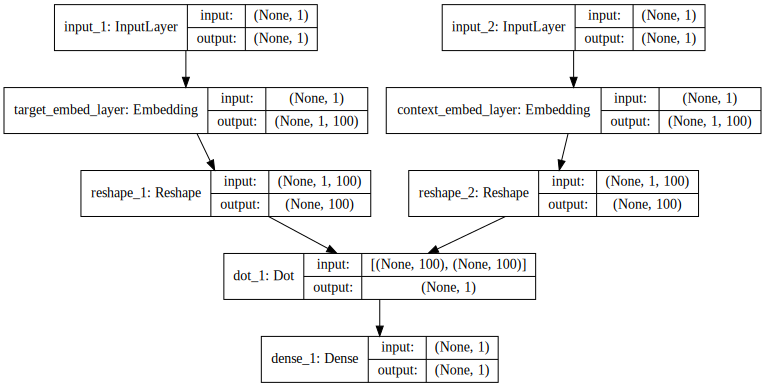

In [23]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model,show_shapes=True,show_layer_names=True).create(prog='dot',format='svg'))

####  6. Training the Model

In [24]:
for epoch in range(1, 6):
    epoch_loss = 0
    # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
            print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences
Instructions for updating:
Use tf.cast instead.
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 1 Loss: 2431.1087396384683 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 2 Loss: 1977.930159447249 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 3 Loss: 1893.1601792802103 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 4 Loss: 1850.5580621440895 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 5 Loss: 1833.0776652768254 



#### 7. Getting the word Embeddings

In [0]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:] #0 was left for padding in sec.3

In [26]:
#sanity check
print(word_embeddings.shape)

(10084, 100)


In [27]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

             0         1         2         3         4         5         6   \
could -0.014317 -0.158415 -0.041629 -0.071060  0.075435 -0.027095  0.047357   
would -0.078762  0.208549 -0.177284 -0.046103 -0.256669  0.173235  0.057353   
mr    -0.053866 -0.223947 -0.000346 -0.138215 -0.047695 -0.032953  0.136809   
mrs   -0.035664 -0.064596  0.107263 -0.111040 -0.036303 -0.076065  0.028441   
must   0.014779 -0.129309 -0.291526  0.085700 -0.009702  0.155365 -0.038107   
said  -0.154192 -0.259603  0.007174  0.100324 -0.039372  0.003552 -0.097250   
one   -0.068846 -0.082051 -0.108731  0.056841  0.029236 -0.099549 -0.182691   
much  -0.024214 -0.210229  0.022031 -0.011355  0.000299 -0.062699  0.016344   
miss  -0.115111 -0.120304 -0.227185 -0.139391 -0.114623  0.176881 -0.061398   
every -0.016221 -0.015918  0.018710 -0.160335  0.082192 -0.123341  0.068876   

             7         8         9     ...           90        91        92  \
could  0.269148 -0.127064  0.024607    ...    -0.24

####  8. Measuring Similarity Between Word Pairs

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)

#check
print(similarity_matrix.shape)

(10084, 10084)


#### 9. Exploring and Visualising the Word Embeddings using t-SNE

9.A Get the most similar words to the seatch items in the list below

In [0]:
search_terms = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']

# Get the 5 words most similar to the search terms
similar_words = {term: [idx2word[idx]
                    for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1] 
                    for term in search_terms}

In [30]:
#Sanity check
print(similar_words)

{'man': ['pastures', 'prettier', 'particulars', 'receiving', 'daughter'], 'love': ['volumes', 'newest', 'blindly', 'add', 'attempted'], 'hatred': ['unpleasing', 'sourness', 'darted', 'shed', 'satisfies'], 'woman': ['thought', 'extremely', 'jemima', 'testifying', 'cared'], 'wisdom': ['softly', 'courting', 'lief', 'devil', 'surpassed'], 'kindness': ['lamenting', 'navy', 'confession', 'glow', 'attractive'], 'god': ['termination', 'capabilities', 'gowns', 'inaccessible', 'lief'], 'folly': ['nipped', 'petticoats', 'brotherly', 'taxed', 'unwillingness'], 'fool': ['idolized', 'resuscitation', 'stylish', 'unwell', 'coxes']}


9.B Plot the words in the dictionary above using t-SNE

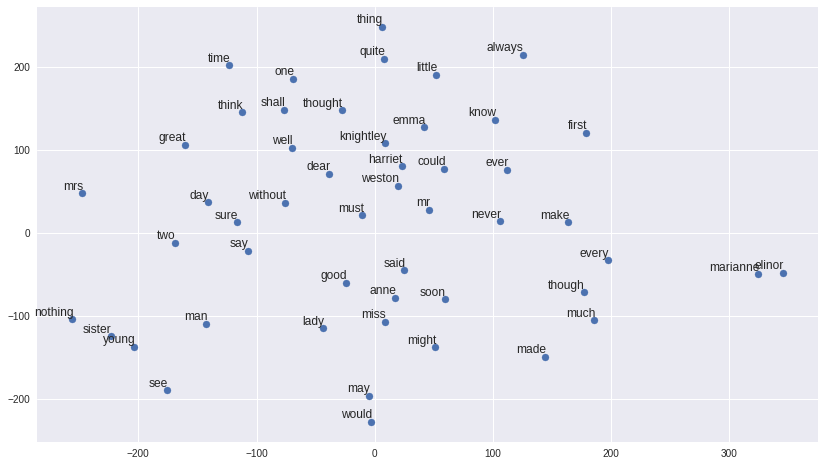

In [31]:
#Plot 500 of the word embeddings:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right',va='bottom')